In [1]:

#Setup Kaggle credentials and download dataset

import os
import json

# Create .kaggle directory
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

# Read kaggle.json (make sure you've uploaded it to /content/)
with open("/content/kaggle.json", "r") as f:
    kaggle_credentials = json.load(f)

# Save credentials in ~/.kaggle/kaggle.json
with open(os.path.join(kaggle_dir, "kaggle.json"), "w") as f:
    json.dump(kaggle_credentials, f)

os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)  # Secure permissions

# Download and extract dataset from Kaggle

dataset_folder = "/content/melanoma_dataset"
os.makedirs(dataset_folder, exist_ok=True)

# Download and unzip
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images -p "{dataset_folder}"
!unzip -q "{dataset_folder}/melanoma-skin-cancer-dataset-of-10000-images.zip" -d "{dataset_folder}"

# Check dataset contents
!ls "{dataset_folder}"


Dataset URL: https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images
License(s): CC0-1.0
  0% 0.00/98.7M [00:00<?, ?B/s]
100% 98.7M/98.7M [00:00<00:00, 1.39GB/s]
melanoma_cancer_dataset  melanoma-skin-cancer-dataset-of-10000-images.zip


In [3]:
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import joblib


In [4]:
def load_data(data_dir):
    features, labels = [], []

    for label, class_name in enumerate(["benign", "malignant"]):
        class_path = os.path.join(data_dir, class_name)

        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img is not None:
                    img = cv2.resize(img, (128, 128))
                    feature_vector = hog(
                        img,
                        pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2),
                        feature_vector=True
                    )
                    features.append(feature_vector)
                    labels.append(label)

    return np.array(features), np.array(labels)


In [5]:
from sklearn.model_selection import train_test_split

# Correct directories
train_dir = os.path.join(dataset_folder, "melanoma_cancer_dataset", "train")
test_dir = os.path.join(dataset_folder, "melanoma_cancer_dataset", "test")

# Load train and test data
X_train_full, y_train_full = load_data(train_dir)
X_test, y_test = load_data(test_dir)

# Create validation split (10% of training)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42, stratify=y_train_full
)

print(f"Train samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("✅ Data scaling complete!")


Train samples: 8644
Validation samples: 961
Test samples: 1000
✅ Data scaling complete!


In [6]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Kernels to test
kernels = ["linear", "poly", "rbf"]

results = []

for kernel in kernels:
    print(f"\n🔹 Training SVM with '{kernel}' kernel...")

    # Initialize model
    svm_model = SVC(kernel=kernel, random_state=42)

    # Train
    svm_model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = svm_model.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)

    # Evaluate on test set
    y_test_pred = svm_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Collect results
    results.append({
        "Kernel": kernel,
        "Validation Accuracy": val_acc,
        "Test Accuracy": test_acc
    })

    # Print reports
    print(f"✅ Validation Accuracy ({kernel}): {val_acc:.4f}")
    print(f"✅ Test Accuracy ({kernel}): {test_acc:.4f}")
    print("\nValidation Classification Report:")
    print(classification_report(y_val, y_val_pred))
    print("\nTest Classification Report:")
    print(classification_report(y_test, y_test_pred))



🔹 Training SVM with 'linear' kernel...
✅ Validation Accuracy (linear): 0.8325
✅ Test Accuracy (linear): 0.8410

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       500
           1       0.82      0.84      0.83       461

    accuracy                           0.83       961
   macro avg       0.83      0.83      0.83       961
weighted avg       0.83      0.83      0.83       961


Test Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       500
           1       0.84      0.84      0.84       500

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000


🔹 Training SVM with 'poly' kernel...
✅ Validation Accuracy (poly): 0.7086
✅ Test Accuracy (poly): 0.7880

Validation Classification Report:
              precision    re


Overall SVM Results:
    Kernel  Validation Accuracy  Test Accuracy
0  linear             0.832466          0.841
1    poly             0.708637          0.788
2     rbf             0.874089          0.885


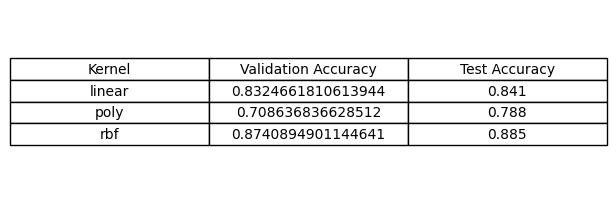


📁 Results saved as image: /content/SVM_Results.png


In [7]:
results_df = pd.DataFrame(results)
print("\nOverall SVM Results:\n", results_df)

# Plot table as image
fig, ax = plt.subplots(figsize=(7, 1.2 + 0.4 * len(results_df)))
ax.axis('off')
table = ax.table(
    cellText=results_df.values,
    colLabels=results_df.columns,
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.1, 1.3)

# Save as PNG
output_path = "/content/SVM_Results.png"
plt.savefig(output_path, bbox_inches='tight', dpi=300)
plt.show()

print(f"\n📁 Results saved as image: {output_path}")